In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision

In [2]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

In [3]:
from torch import nn
import torch.nn.functional as F

IMG_SIZE=32
NUM_CLASSES = 10
TRAINING_BATCH_SIZE = 16
TESTING_BATCH_SIZE = 100

# AlexNet
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        print("Init:")
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        x = torch.randn(3, IMG_SIZE, IMG_SIZE).view(-1, 3, IMG_SIZE, IMG_SIZE)
        self._to_linear = None
        self.convs(x)
        
        print(x.shape)
        print(self._to_linear)
        
        self.classifier = nn.Sequential(
            nn.Linear(self._to_linear, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10),
            nn.Softmax(dim=1),
        )
        
    def convs(self, x):
        # print("Conv")
        # print(x.shape)
        assert x.ndim >= 2 and x.shape[1] == 3
        
        x = self.features(x)
        
        self._to_linear = x.flatten(start_dim=1).shape[1]
        
        return x
    
    def forward(self, x):
        # print("Forwarding:")
        # print(x.shape)
        
        x = self.convs(x)        
        x = x.flatten(start_dim=1)

        x = self.classifier(x)

        return x
    
Net()

Init:
torch.Size([1, 3, 32, 32])
1152


/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

In [14]:
import os
import time
import random
from tqdm import tqdm

class Learning():
    def __init__(self, model, optimizer, loss_fn, training_dataloader, testing_dataloader, transform_y, device, img_size: int, epochs: int):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.training_dataloader = training_dataloader
        self.testing_dataloader = testing_dataloader
        self.testing_batch = list(iter(testing_dataloader))
        
        self.transform_y = transform_y
        self.img_size = img_size
        
        self.device = device
        print(self.device)
        self.log_path = f"/logs/{int(time.time())}.csv"

    def train(self):
        for epoch in range(self.epochs):
            accs = []
            losses = []
            for i, (batch_X, batch_y) in enumerate(tqdm(iter(self.training_dataloader), desc="Epoch " + str(epoch + 1))):
                # print("Training:")
                # print(batch_y.shape)
                batch_X = batch_X.to(dtype=torch.float32, device=self.device)
                batch_y = batch_y.to(device=self.device)
                
                acc, loss = self._fwd_pass(batch_X, batch_y)
                accs.append(acc)
                losses.append(loss.to(device='cpu').detach().numpy())

            acc = np.asarray(accs).mean()
            loss = np.asarray(losses).mean()
            print("Acc:", acc)
            print("Loss:", loss)

            val_acc, val_loss = self.test()
            self.log_to_file(str(epoch), acc, loss, val_acc, val_loss)
            print("Val Acc:", val_acc)
            print("Val Loss:", val_loss)
            
    def overfit(self, epochs: int = 10, total_batches: int = 2):
        iterator = iter(self.training_dataloader)
        overfit_data = [next(iterator) for _ in range(total_batches)]
        
        accs = []
        losses = []
        for epoch in range(1,epochs + 1):
            for i, (batch_X, batch_y) in enumerate(tqdm(overfit_data, total=total_batches, desc="Epoch " + str(epoch))):
                # print("Training:")
                batch_X = batch_X.to(dtype=torch.float32, device=self.device)
                batch_y = batch_y.to(device=self.device)
                
                acc, loss = self._fwd_pass(batch_X, batch_y)
            
            accs.append(acc)
            losses.append(loss.to(device='cpu').detach().numpy())
            
        val_acc, val_loss = self.test()
        print("Val Acc:", val_acc)
        print("Val Loss:", val_loss)
        
        plt.plot(range(1,epochs + 1), accs, range(1,epochs + 1), losses)
        plt.gca().legend(('Accuracy','Loss'))
        plt.ylabel("Training")
        plt.xlabel("Epoch")
        plt.show()
        

    def test(self):
        i = random.randint(0, len(self.testing_batch) - 1)
        batch_X, batch_y = self.testing_batch[i]
        
        batch_X = batch_X.to(dtype=torch.float32, device=self.device).view(-1, 3, self.img_size, self.img_size)
        batch_y = self.transform_y(batch_y).to(device=self.device)
        
        acc, loss = self._eval(batch_X, batch_y)

        return acc, loss
    

    def _fwd_pass(self, X, y):
        self.optimizer.zero_grad()
        
        output = self.model(X)
        y = self.transform_y(y)
        
        # print(y.shape)
        # print(output.shape)
        # print(y.dtype)
        # print(output.dtype)
        # print(output[0])
        loss = self.loss_fn(output, y).to(device=self.device)

        n_matches = torch.count_nonzero(torch.argmax(output, dim=1) == y).item()
        
        loss.backward()
        self.optimizer.step()
            
        return round(n_matches / len(X), 2), loss
        
    def _eval(self, X, y):
        with torch.no_grad():
            self.model.eval()
                
            output = self.model(X)
            y = self.transform_y(y)

            loss = self.loss_fn(output, y)

            n_matches = torch.count_nonzero(torch.argmax(output, dim=1) == y).item()
                
            return round(n_matches / len(X), 2), loss
    
    def log_to_file(self, id: str, train_acc, train_loss, val_acc, val_loss):
        append = f"{id},{train_acc},{train_loss},{val_acc},{val_loss}\n"
        full_path = os.path.abspath(os.getcwd()) + self.log_path
        
        with open(full_path, "a") as f:
            if os.path.getsize(full_path) <= 0:
                f.write("id,train_acc,train_loss,val_acc,val_loss\n")
                
            f.write(append)
            

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100000


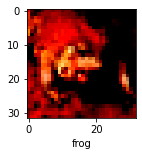

In [5]:
from torchvision import transforms
from torch import optim
import numpy as np

def find_mean_std(dataset):
    assert dataset.ndim >= 2
    print(dataset.shape)
    
    temp = dataset.reshape(dataset.shape[-1], -1)
    
    print(temp.shape)
    
    return np.array(temp.mean(axis=1)) / 255.0, np.array(temp.std(axis=1)) / 255.0
    
    
training_norm = {
    'mean': np.array([0.47410759, 0.4726623 , 0.47331911]), 
    'std': np.array([0.2520572 , 0.25201249, 0.25063239])
}
testing_norm = {
    'mean': np.array([0.48003726, 0.47553964, 0.47417786]), 
    'std': np.array([0.25093406, 0.25146236, 0.25122434])
}

training_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomAdjustSharpness(0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=training_norm['mean'], std=training_norm['std'])
])

testing_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=testing_norm['mean'], std=testing_norm['std'])
])

NUM_AUG = 2
training_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.CIFAR10(root="./data", train=True, transform=training_transforms, download=True) for _ in range(NUM_AUG)])
training_dataloader = torch.utils.data.DataLoader(training_dataset, shuffle=True, batch_size=TRAINING_BATCH_SIZE)

testing_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=testing_transforms, download=True)
testing_dataloader = torch.utils.data.DataLoader(testing_dataset, 
                                                 shuffle=True, 
                                                 batch_size=TESTING_BATCH_SIZE)


index = 5
dataset = testing_dataset
plt.figure(figsize = (15,2))
# print(dataset[index][0].shape)
#.view(dataset[index][0].shape[1], dataset[index][0].shape[2], dataset[index][0].shape[0])
plt.imshow(dataset[index][0].permute(1, 2, 0))
plt.xlabel(classes[dataset[index][1]])

print(len(training_dataloader) * TRAINING_BATCH_SIZE)
# print(testing_dataset[0][0] /255)

# print(find_mean_std(training_dataset.data))
# print(find_mean_std(testing_dataset.data))

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
to_overfit = False

net = Net().to(device=device)

# net = torchvision.models.DenseNet(
#     growth_rate = 16, # how many filters to add each layer (`k` in paper)
#     block_config = (6, 12, 24, 16), # how many layers in each pooling block
#     num_init_features = 16, # the number of filters to learn in the first convolution layer (k0)
#     bn_size= 4, # multiplicative factor for number of bottleneck (1x1 cons) layers
#     drop_rate = 0, # dropout rate after each dense conv layer
#     num_classes = NUM_CLASSES # number of classification classes
# ).to(device=device)

net = torchvision.models.resnet18(
    pretrained=True,
)

#Freeze params
for name, param in net.named_parameters(): 
    if("bn" not in name):
        param.requires_grad = False
        
net.fc = nn.Sequential(
    nn.Linear(net.fc.in_features,500),
    nn.ReLU(),
    nn.Dropout(p=0.0 if to_overfit else 0.1), 
    nn.Linear(500, NUM_CLASSES)
)

net = net.to(device=device)

learning = Learning(
    model=net,
    optimizer=optim.Adam(net.parameters(), lr=3e-4, weight_decay=0),
    # loss_fn=nn.MSELoss(),
    loss_fn=nn.CrossEntropyLoss(),
    img_size=IMG_SIZE,
    training_dataloader=training_dataloader,
    testing_dataloader=testing_dataloader,
    device=device,
    # transform_y=lambda y: F.one_hot(y.long(), num_classes=NUM_CLASSES).to(dtype=torch.float32),
    transform_y=lambda y: y,
    epochs=5,
)

if to_overfit:
  learning.overfit(epochs=10, total_batches=1)
else:
  learning.train()

Init:
torch.Size([1, 3, 32, 32])
1152


Epoch 1:   0%|          | 1/6250 [00:00<10:56,  9.51it/s]

cpu


Epoch 1:   8%|▊         | 500/6250 [00:58<12:00,  7.98it/s]

In [ ]:
# Acc: 0.808212
# Loss: 0.5360819
# Val Acc: 0.72
# Val Loss: tensor(0.8811, device='cuda:0')
torch.save(net.state_dict(), 'image_classification_resnet18.pth')